In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [4]:
# Load

try:
    train_set
except:
    train_set = pd.read_csv("data/diabetes_train_set.csv")
    
train_set.shape

(81412, 50)

In [5]:
diabetes = train_set.copy()

# Análises

## Variáveis categóricas

### 📌

`admission_type_id`, `discharge_disposition_id`, `admission_source_id`, `race` são variáveis que possuem relativas altas cardinalidades, mas possuem valores muito mais frequentes que outros.

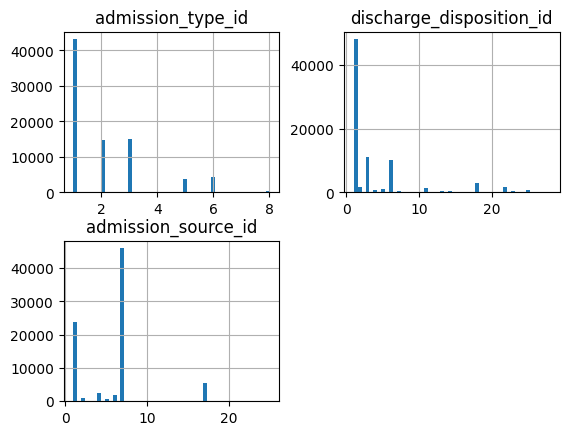

race           
Caucasian          60920
AfricanAmerican    15354
?                   1820
Hispanic            1624
Other               1198
Asian                496
Name: count, dtype: int64

In [4]:
diabetes[
    [
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id",
    ]
].hist(bins=50)
plt.show()


diabetes[["race"]].value_counts()

## Variáveis de dosagem de medicamento

### 📌

`admission_type_id`, `discharge_disposition_id`, `admission_source_id`, `medical_specialty` são variáveis que possuem relativas altas cardinalidades, mas possuem valores muito mais frequentes que outros.

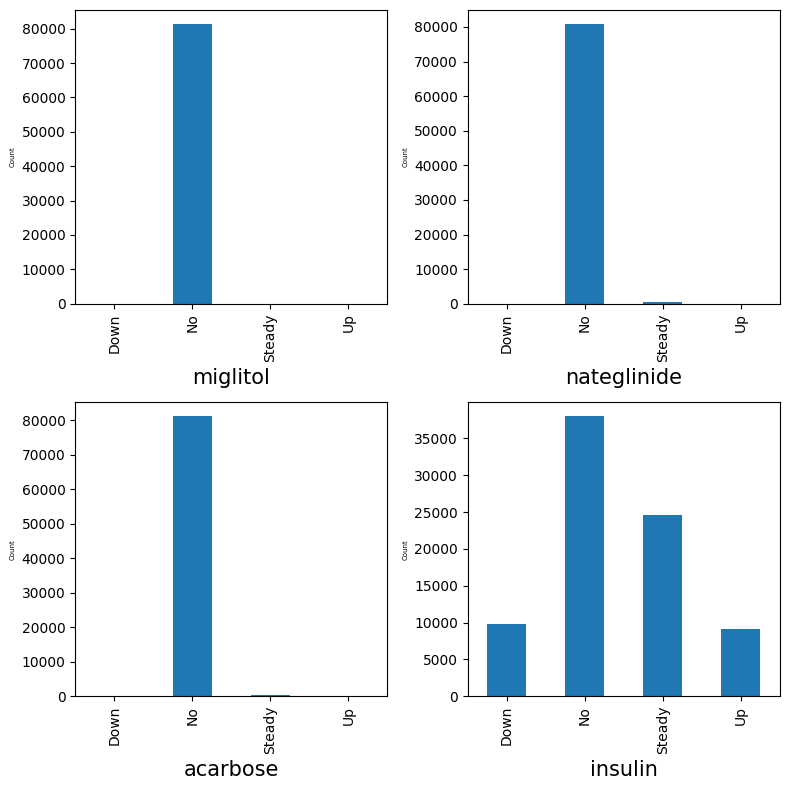

In [5]:
# Plot
fig = plt.figure(figsize = (8,8))

ax1 = fig.add_subplot(221)
ax1 = diabetes.groupby('miglitol').size().plot(kind = 'bar')
plt.xlabel('miglitol', fontsize = 15)
plt.ylabel('Count', fontsize = 5)

ax2 = fig.add_subplot(222)
ax2 = diabetes.groupby('nateglinide').size().plot(kind = 'bar')
plt.xlabel('nateglinide', fontsize = 15)
plt.ylabel('Count', fontsize = 5)

ax3 = fig.add_subplot(223)
ax3 = diabetes.groupby('acarbose').size().plot(kind = 'bar')
plt.xlabel('acarbose', fontsize = 15)
plt.ylabel('Count', fontsize = 5)

ax4 = fig.add_subplot(224)
ax4 = diabetes.groupby('insulin').size().plot(kind = 'bar')
plt.xlabel('insulin', fontsize = 15)
plt.ylabel('Count', fontsize = 5)

plt.tight_layout()
plt.show()

# Implementação auxiliar

## Limpeza dos dados

- ✅ Elimina colunas com muitos valores núlos
- ✅ Elimina linhas com valores nulos
- ✅ Elimina colunas que possuem registro de um só valor

In [6]:
class DropColumnsHighMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        """
        Parâmetros:
            threshold: limiar para a proporção de valores ausentes.
        """
        self.threshold = threshold

    def fit(self, X, y=None):
        # Identifica colunas com muitos NaN
        null_mean = X.isnull().mean()
        self.cols_to_drop_ = null_mean[null_mean > self.threshold].index.to_list()

        # Identifica colunas com muitos '?'
        null_mean = []
        for col in X.columns:
            mean = X[X[col] == "?"].shape[0] / X.shape[0]
            if mean > self.threshold:
                self.cols_to_drop_.append(col)

        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_)


class DropRowsInvalidValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        missing_markers = ["?", "Unknown/Invalid"]

        X = X.copy()

        # Exclui linhas com valores NaN
        X.dropna(inplace=True)
        # Exclui linhas com valores "?" ou "Unknown/Invalid"
        for col in X.columns:
            X = X[~X[col].isin(missing_markers)]

        return X


class DropSingleValueColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Identifica colunas com apenas um valor
        self.cols_to_drop_ = X.columns[X.nunique() == 1].tolist()
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_)

In [7]:
clean_up_pipeline = Pipeline([
    ("drop_hight_missing", DropColumnsHighMissingValues(threshold=0.2)),
    ("drop_invalid_values", DropRowsInvalidValues()),
    ("drop_single_value", DropSingleValueColumns()),
])

## Feature Engineering

- ✅ Trata dados categóricos com poucos dados frequentes
- ✅ Tratar `age`
- ✅ Tratar dados de medicamento
- ✅ Tratar dados de diagnostico
- ✅ Tratar outros dados categóricos binários

In [8]:
class GroupUncommon1HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attributes: list[str], threshold: float = 0.02):
        """
        Parâmetros:
            attributes: Lista das colunas a serem transformadas.
            threshold: Frequência mínima para que um valor seja considerado frequente.
        """
        self.attributes = attributes
        self.threshold = threshold

    def fit(self, X, y=None):
        # Dicionário para salvar os valores frequentes de cada coluna
        self.frequent_values_ = {}
        for col in self.attributes:
            if col not in X.columns:
                continue
            # Calcula a frequência relativa dos valores
            value_counts = X[col].value_counts(normalize=True)
            # Seleciona os valores cuja frequência é maior ou igual ao threshold
            self.frequent_values_[col] = value_counts[
                value_counts >= self.threshold
            ].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()  # Evita modificar o DataFrame original
        encoded_dfs = []  # Lista para armazenar os DataFrames one-hot encoded

        for col in self.attributes:
            if col not in X.columns:
                continue
            # Obtém os valores frequentes para a coluna atual
            frequent = self.frequent_values_.get(col, [])
            # Substitui os valores raros por "Outros"
            X[col] = X[col].apply(lambda x: x if x in frequent else "Others")
            # Realiza o one-hot encoding usando pd.get_dummies
            dummies = pd.get_dummies(X[col], prefix=col)
            encoded_dfs.append(dummies)
            # Remove a coluna original, pois ela será substituída pelas dummies
            X = X.drop(columns=[col])

        # Concatena os dummies com o DataFrame original (com as demais colunas)
        X_transformed = pd.concat([X] + encoded_dfs, axis=1)
        return X_transformed


class CatToNumEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attributes: list[tuple[str, dict[str:int]]]):
        self.attributes = attributes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        for col, mapping in self.attributes:
            if col in X.columns:
                X["num_" + col] = X[col].map(mapping)
                X = X.drop(columns=[col])

        return X

In [9]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, drop_first=False):
        """
        Parâmetros:
          columns: lista de colunas a serem codificadas. Se None, serão detectadas automaticamente.
          drop_first: se True, remove a primeira categoria para evitar multicolinearidade.
        """
        self.columns = columns
        self.drop_first = drop_first

    def fit(self, X, y=None):
        # Se as colunas não forem especificadas, detecta as categóricas
        if self.columns is None:
            self.columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
        # Calcula as colunas dummy a partir do dataset de fit
        dummies = pd.get_dummies(X[self.columns], drop_first=self.drop_first)
        self.dummy_columns_ = dummies.columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        # Gera os dummies para as colunas especificadas
        dummies = pd.get_dummies(X[self.columns], drop_first=self.drop_first)
        # Reindexa para garantir que as mesmas colunas aprendidas no fit estejam presentes,
        # preenchendo com 0 as colunas ausentes
        dummies = dummies.reindex(columns=self.dummy_columns_, fill_value=0)
        # Remove as colunas originais e concatena com os dummies
        X = X.drop(columns=self.columns)
        X_transformed = pd.concat([X, dummies], axis=1)
        return X_transformed

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)


In [10]:
class DiagAttributes(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        df["level1_diag1"] = df["diag_1"]
        df["level2_diag1"] = df["diag_1"]
        df["level1_diag2"] = df["diag_2"]
        df["level2_diag2"] = df["diag_2"]
        df["level1_diag3"] = df["diag_3"]
        df["level2_diag3"] = df["diag_3"]

        df.loc[df["diag_1"].str.contains("V"), ["level1_diag1", "level2_diag1"]] = 0
        df.loc[df["diag_1"].str.contains("E"), ["level1_diag1", "level2_diag1"]] = 0
        df.loc[df["diag_2"].str.contains("V"), ["level1_diag2", "level2_diag2"]] = 0
        df.loc[df["diag_2"].str.contains("E"), ["level1_diag2", "level2_diag2"]] = 0
        df.loc[df["diag_3"].str.contains("V"), ["level1_diag3", "level2_diag3"]] = 0
        df.loc[df["diag_3"].str.contains("E"), ["level1_diag3", "level2_diag3"]] = 0
        df["level1_diag1"] = df["level1_diag1"].replace("?", -1)
        df["level2_diag1"] = df["level2_diag1"].replace("?", -1)
        df["level1_diag2"] = df["level1_diag2"].replace("?", -1)
        df["level2_diag2"] = df["level2_diag2"].replace("?", -1)
        df["level1_diag3"] = df["level1_diag3"].replace("?", -1)
        df["level2_diag3"] = df["level2_diag3"].replace("?", -1)

        df["level1_diag1"] = df["level1_diag1"].astype(float)
        df["level2_diag1"] = df["level2_diag1"].astype(float)
        df["level1_diag2"] = df["level1_diag2"].astype(float)
        df["level2_diag2"] = df["level2_diag2"].astype(float)
        df["level1_diag3"] = df["level1_diag3"].astype(float)
        df["level2_diag3"] = df["level2_diag3"].astype(float)

        for index, row in df.iterrows():
            if (row["level1_diag1"] >= 390 and row["level1_diag1"] < 460) or (
                np.floor(row["level1_diag1"]) == 785
            ):
                df.loc[index, "level1_diag1"] = 1
            elif (row["level1_diag1"] >= 460 and row["level1_diag1"] < 520) or (
                np.floor(row["level1_diag1"]) == 786
            ):
                df.loc[index, "level1_diag1"] = 2
            elif (row["level1_diag1"] >= 520 and row["level1_diag1"] < 580) or (
                np.floor(row["level1_diag1"]) == 787
            ):
                df.loc[index, "level1_diag1"] = 3
            elif np.floor(row["level1_diag1"]) == 250:
                df.loc[index, "level1_diag1"] = 4
            elif row["level1_diag1"] >= 800 and row["level1_diag1"] < 1000:
                df.loc[index, "level1_diag1"] = 5
            elif row["level1_diag1"] >= 710 and row["level1_diag1"] < 740:
                df.loc[index, "level1_diag1"] = 6
            elif (row["level1_diag1"] >= 580 and row["level1_diag1"] < 630) or (
                np.floor(row["level1_diag1"]) == 788
            ):
                df.loc[index, "level1_diag1"] = 7
            elif row["level1_diag1"] >= 140 and row["level1_diag1"] < 240:
                df.loc[index, "level1_diag1"] = 8
            else:
                df.loc[index, "level1_diag1"] = 0

            if (row["level1_diag2"] >= 390 and row["level1_diag2"] < 460) or (
                np.floor(row["level1_diag2"]) == 785
            ):
                df.loc[index, "level1_diag2"] = 1
            elif (row["level1_diag2"] >= 460 and row["level1_diag2"] < 520) or (
                np.floor(row["level1_diag2"]) == 786
            ):
                df.loc[index, "level1_diag2"] = 2
            elif (row["level1_diag2"] >= 520 and row["level1_diag2"] < 580) or (
                np.floor(row["level1_diag2"]) == 787
            ):
                df.loc[index, "level1_diag2"] = 3
            elif np.floor(row["level1_diag2"]) == 250:
                df.loc[index, "level1_diag2"] = 4
            elif row["level1_diag2"] >= 800 and row["level1_diag2"] < 1000:
                df.loc[index, "level1_diag2"] = 5
            elif row["level1_diag2"] >= 710 and row["level1_diag2"] < 740:
                df.loc[index, "level1_diag2"] = 6
            elif (row["level1_diag2"] >= 580 and row["level1_diag2"] < 630) or (
                np.floor(row["level1_diag2"]) == 788
            ):
                df.loc[index, "level1_diag2"] = 7
            elif row["level1_diag2"] >= 140 and row["level1_diag2"] < 240:
                df.loc[index, "level1_diag2"] = 8
            else:
                df.loc[index, "level1_diag2"] = 0

            if (row["level1_diag3"] >= 390 and row["level1_diag3"] < 460) or (
                np.floor(row["level1_diag3"]) == 785
            ):
                df.loc[index, "level1_diag3"] = 1
            elif (row["level1_diag3"] >= 460 and row["level1_diag3"] < 520) or (
                np.floor(row["level1_diag3"]) == 786
            ):
                df.loc[index, "level1_diag3"] = 2
            elif (row["level1_diag3"] >= 520 and row["level1_diag3"] < 580) or (
                np.floor(row["level1_diag3"]) == 787
            ):
                df.loc[index, "level1_diag3"] = 3
            elif np.floor(row["level1_diag3"]) == 250:
                df.loc[index, "level1_diag3"] = 4
            elif row["level1_diag3"] >= 800 and row["level1_diag3"] < 1000:
                df.loc[index, "level1_diag3"] = 5
            elif row["level1_diag3"] >= 710 and row["level1_diag3"] < 740:
                df.loc[index, "level1_diag3"] = 6
            elif (row["level1_diag3"] >= 580 and row["level1_diag3"] < 630) or (
                np.floor(row["level1_diag3"]) == 788
            ):
                df.loc[index, "level1_diag3"] = 7
            elif row["level1_diag3"] >= 140 and row["level1_diag3"] < 240:
                df.loc[index, "level1_diag3"] = 8
            else:
                df.loc[index, "level1_diag3"] = 0

        for index, row in df.iterrows():
            if row["level2_diag1"] >= 390 and row["level2_diag1"] < 399:
                df.loc[index, "level2_diag1"] = 1
            elif row["level2_diag1"] >= 401 and row["level2_diag1"] < 415:
                df.loc[index, "level2_diag1"] = 2
            elif row["level2_diag1"] >= 415 and row["level2_diag1"] < 460:
                df.loc[index, "level2_diag1"] = 3
            elif np.floor(row["level2_diag1"]) == 785:
                df.loc[index, "level2_diag1"] = 4
            elif row["level2_diag1"] >= 460 and row["level2_diag1"] < 489:
                df.loc[index, "level2_diag1"] = 5
            elif row["level2_diag1"] >= 490 and row["level2_diag1"] < 497:
                df.loc[index, "level2_diag1"] = 6
            elif row["level2_diag1"] >= 500 and row["level2_diag1"] < 520:
                df.loc[index, "level2_diag1"] = 7
            elif np.floor(row["level2_diag1"]) == 786:
                df.loc[index, "level2_diag1"] = 8
            elif row["level2_diag1"] >= 520 and row["level2_diag1"] < 530:
                df.loc[index, "level2_diag1"] = 9
            elif row["level2_diag1"] >= 530 and row["level2_diag1"] < 544:
                df.loc[index, "level2_diag1"] = 10
            elif row["level2_diag1"] >= 550 and row["level2_diag1"] < 554:
                df.loc[index, "level2_diag1"] = 11
            elif row["level2_diag1"] >= 555 and row["level2_diag1"] < 580:
                df.loc[index, "level2_diag1"] = 12
            elif np.floor(row["level2_diag1"]) == 787:
                df.loc[index, "level2_diag1"] = 13
            elif np.floor(row["level2_diag1"]) == 250:
                df.loc[index, "level2_diag1"] = 14
            elif row["level2_diag1"] >= 800 and row["level2_diag1"] < 1000:
                df.loc[index, "level2_diag1"] = 15
            elif row["level2_diag1"] >= 710 and row["level2_diag1"] < 740:
                df.loc[index, "level2_diag1"] = 16
            elif row["level2_diag1"] >= 580 and row["level2_diag1"] < 630:
                df.loc[index, "level2_diag1"] = 17
            elif np.floor(row["level2_diag1"]) == 788:
                df.loc[index, "level2_diag1"] = 18
            elif row["level2_diag1"] >= 140 and row["level2_diag1"] < 240:
                df.loc[index, "level2_diag1"] = 19
            elif (
                row["level2_diag1"] >= 240
                and row["level2_diag1"] < 280
                and (np.floor(row["level2_diag1"]) != 250)
            ):
                df.loc[index, "level2_diag1"] = 20
            elif (row["level2_diag1"] >= 680 and row["level2_diag1"] < 710) or (
                np.floor(row["level2_diag1"]) == 782
            ):
                df.loc[index, "level2_diag1"] = 21
            elif row["level2_diag1"] >= 290 and row["level2_diag1"] < 320:
                df.loc[index, "level2_diag1"] = 22
            else:
                df.loc[index, "level2_diag1"] = 0

            if row["level2_diag2"] >= 390 and row["level2_diag2"] < 399:
                df.loc[index, "level2_diag2"] = 1
            elif row["level2_diag2"] >= 401 and row["level2_diag2"] < 415:
                df.loc[index, "level2_diag2"] = 2
            elif row["level2_diag2"] >= 415 and row["level2_diag2"] < 460:
                df.loc[index, "level2_diag2"] = 3
            elif np.floor(row["level2_diag2"]) == 785:
                df.loc[index, "level2_diag2"] = 4
            elif row["level2_diag2"] >= 460 and row["level2_diag2"] < 489:
                df.loc[index, "level2_diag2"] = 5
            elif row["level2_diag2"] >= 490 and row["level2_diag2"] < 497:
                df.loc[index, "level2_diag2"] = 6
            elif row["level2_diag2"] >= 500 and row["level2_diag2"] < 520:
                df.loc[index, "level2_diag2"] = 7
            elif np.floor(row["level2_diag2"]) == 786:
                df.loc[index, "level2_diag2"] = 8
            elif row["level2_diag2"] >= 520 and row["level2_diag2"] < 530:
                df.loc[index, "level2_diag2"] = 9
            elif row["level2_diag2"] >= 530 and row["level2_diag2"] < 544:
                df.loc[index, "level2_diag2"] = 10
            elif row["level2_diag2"] >= 550 and row["level2_diag2"] < 554:
                df.loc[index, "level2_diag2"] = 11
            elif row["level2_diag2"] >= 555 and row["level2_diag2"] < 580:
                df.loc[index, "level2_diag2"] = 12
            elif np.floor(row["level2_diag2"]) == 787:
                df.loc[index, "level2_diag2"] = 13
            elif np.floor(row["level2_diag2"]) == 250:
                df.loc[index, "level2_diag2"] = 14
            elif row["level2_diag2"] >= 800 and row["level2_diag2"] < 1000:
                df.loc[index, "level2_diag2"] = 15
            elif row["level2_diag2"] >= 710 and row["level2_diag2"] < 740:
                df.loc[index, "level2_diag2"] = 16
            elif row["level2_diag2"] >= 580 and row["level2_diag2"] < 630:
                df.loc[index, "level2_diag2"] = 17
            elif np.floor(row["level2_diag2"]) == 788:
                df.loc[index, "level2_diag2"] = 18
            elif row["level2_diag2"] >= 140 and row["level2_diag2"] < 240:
                df.loc[index, "level2_diag2"] = 19
            elif (
                row["level2_diag2"] >= 240
                and row["level2_diag2"] < 280
                and (np.floor(row["level2_diag2"]) != 250)
            ):
                df.loc[index, "level2_diag2"] = 20
            elif (row["level2_diag2"] >= 680 and row["level2_diag2"] < 710) or (
                np.floor(row["level2_diag2"]) == 782
            ):
                df.loc[index, "level2_diag2"] = 21
            elif row["level2_diag2"] >= 290 and row["level2_diag2"] < 320:
                df.loc[index, "level2_diag2"] = 22
            else:
                df.loc[index, "level2_diag2"] = 0

            if row["level2_diag3"] >= 390 and row["level2_diag3"] < 399:
                df.loc[index, "level2_diag3"] = 1
            elif row["level2_diag3"] >= 401 and row["level2_diag3"] < 415:
                df.loc[index, "level2_diag3"] = 2
            elif row["level2_diag3"] >= 415 and row["level2_diag3"] < 460:
                df.loc[index, "level2_diag3"] = 3
            elif np.floor(row["level2_diag3"]) == 785:
                df.loc[index, "level2_diag3"] = 4
            elif row["level2_diag3"] >= 460 and row["level2_diag3"] < 489:
                df.loc[index, "level2_diag3"] = 5
            elif row["level2_diag3"] >= 490 and row["level2_diag3"] < 497:
                df.loc[index, "level2_diag3"] = 6
            elif row["level2_diag3"] >= 500 and row["level2_diag3"] < 520:
                df.loc[index, "level2_diag3"] = 7
            elif np.floor(row["level2_diag3"]) == 786:
                df.loc[index, "level2_diag3"] = 8
            elif row["level2_diag3"] >= 520 and row["level2_diag3"] < 530:
                df.loc[index, "level2_diag3"] = 9
            elif row["level2_diag3"] >= 530 and row["level2_diag3"] < 544:
                df.loc[index, "level2_diag3"] = 10
            elif row["level2_diag3"] >= 550 and row["level2_diag3"] < 554:
                df.loc[index, "level2_diag3"] = 11
            elif row["level2_diag3"] >= 555 and row["level2_diag3"] < 580:
                df.loc[index, "level2_diag3"] = 12
            elif np.floor(row["level2_diag3"]) == 787:
                df.loc[index, "level2_diag3"] = 13
            elif np.floor(row["level2_diag3"]) == 250:
                df.loc[index, "level2_diag3"] = 14
            elif row["level2_diag3"] >= 800 and row["level2_diag3"] < 1000:
                df.loc[index, "level2_diag3"] = 15
            elif row["level2_diag3"] >= 710 and row["level2_diag3"] < 740:
                df.loc[index, "level2_diag3"] = 16
            elif row["level2_diag3"] >= 580 and row["level2_diag3"] < 630:
                df.loc[index, "level2_diag3"] = 17
            elif np.floor(row["level2_diag3"]) == 788:
                df.loc[index, "level2_diag3"] = 18
            elif row["level2_diag3"] >= 140 and row["level2_diag3"] < 240:
                df.loc[index, "level2_diag3"] = 19
            elif (
                row["level2_diag3"] >= 240
                and row["level2_diag3"] < 280
                and (np.floor(row["level2_diag3"]) != 250)
            ):
                df.loc[index, "level2_diag3"] = 20
            elif (row["level2_diag3"] >= 680 and row["level2_diag3"] < 710) or (
                np.floor(row["level2_diag3"]) == 782
            ):
                df.loc[index, "level2_diag3"] = 21
            elif row["level2_diag3"] >= 290 and row["level2_diag3"] < 320:
                df.loc[index, "level2_diag3"] = 22
            else:
                df.loc[index, "level2_diag3"] = 0

        return df.drop(columns=["diag_1", "diag_2", "diag_3"])

## Pipeline final

In [11]:
dummy_attrbs = [
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
]

mapping_age = {
    "[0-10)": 5,
    "[10-20)": 15,
    "[20-30)": 25,
    "[30-40)": 35,
    "[40-50)": 45,
    "[50-60)": 55,
    "[60-70)": 65,
    "[70-80)": 75,
    "[80-90)": 85,
    "[90-100)": 95,
}

mapping_med = {
    "No": 0,
    "Steady": 1,
    "Up": 2,
    "Down": 3,
}

cat_attrbs = [
    # Age
    ("age", mapping_age),
    # Medicamentos
    ("metformin", mapping_med),
    ("repaglinide", mapping_med),
    ("nateglinide", mapping_med),
    ("chlorpropamide", mapping_med),
    ("glimepiride", mapping_med),
    ("acetohexamide", mapping_med),
    ("glipizide", mapping_med),
    ("glyburide", mapping_med),
    ("tolbutamide", mapping_med),
    ("pioglitazone", mapping_med),
    ("rosiglitazone", mapping_med),
    ("acarbose", mapping_med),
    ("miglitol", mapping_med),
    ("troglitazone", mapping_med),
    ("tolazamide", mapping_med),
    ("examide", mapping_med),
    ("citoglipton", mapping_med),
    ("insulin", mapping_med),
    ("glyburide.metformin", mapping_med),
    ("glipizide.metformin", mapping_med),
    ("glimepiride.pioglitazone", mapping_med),
    ("metformin.rosiglitazone", mapping_med),
    ("metformin.pioglitazone", mapping_med),
    # Outras variáveis binárias
    ("change", {"No": 0, "Ch": 1}),
    ("gender", {"Female": 0, "Male": 1}),
    ("diabetesMed", {"No": 0, "Yes": 1}),
]

In [12]:
pipeline = Pipeline([
    ('group_encoder', GroupUncommon1HotEncoder(attributes=dummy_attrbs, threshold=0.02)),
    ('diag_attrbs', DiagAttributes()),
    ('cat2num', CatToNumEncoder(attributes=cat_attrbs)),
    ('custom1hot', CustomOneHotEncoder(columns=["race"])),
    ('drop_ids', DropColumns(columns=["encounter_id", "patient_nbr"])),
    ('scaler', MinMaxScaler())
])

In [ ]:
diabetes_cleaned = clean_up_pipeline.fit_transform(diabetes)

X = diabetes_cleaned.drop(columns=["readmitted"])
y = diabetes_cleaned["readmitted"].copy()

X_prepared = pipeline.fit_transform(X)

y_prepared = CustomOneHotEncoder().fit_transform(y.to_frame())
y_prepared = MinMaxScaler().fit_transform(y_prepared)

In [47]:
X_prepared

array([[0.38461538, 0.42748092, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.15384615, 0.29007634, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.28244275, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07692308, 0.38931298, 0.16666667, ..., 1.        , 0.        ,
        0.        ],
       [0.15384615, 0.27480916, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [0.46153846, 0.25954198, 0.33333333, ..., 0.        , 0.        ,
        0.        ]], shape=(78430, 59))

In [39]:
y_prepared

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], shape=(78430, 3))

In [49]:
np.save("data/diabetes_train_dados.npy", X_prepared)
np.save("data/diabetes_train_labels.npy", y_prepared)

In [ ]:
# Load

try:
    test_set
except:
    test_set = pd.read_csv("data/diabetes_test_set.csv")
    
diabetes = test_set.copy()

diabetes_cleaned = clean_up_pipeline.fit_transform(diabetes)

X_ = diabetes_cleaned.drop(columns=["readmitted"])
y_ = diabetes_cleaned["readmitted"].copy()

X_prepared_ = pipeline.fit_transform(X_)

y_prepared_ = CustomOneHotEncoder().fit_transform(y_.to_frame())
y_prepared_ = MinMaxScaler().fit_transform(y_prepared_)

np.save("data/diabetes_test_dados.npy", X_prepared_)
np.save("data/diabetes_test_labels.npy", y_prepared_)

In [16]:
y_prepared_

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], shape=(19622, 3))

In [ ]:
import numpy as np

X_train = np.load("data/diabetes_train_dados.npy", allow_pickle=True)
y_train = np.load("data/diabetes_train_labels.npy", allow_pickle=True)
X_test = np.load("data/diabetes_test_dados.npy", allow_pickle=True)
y_test = np.load("data/diabetes_test_labels.npy", allow_pickle=True)



In [2]:
data

array([[0.38461538, 0.42748092, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.15384615, 0.29007634, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.28244275, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07692308, 0.38931298, 0.16666667, ..., 1.        , 0.        ,
        0.        ],
       [0.15384615, 0.27480916, 0.33333333, ..., 1.        , 0.        ,
        0.        ],
       [0.46153846, 0.25954198, 0.33333333, ..., 0.        , 0.        ,
        0.        ]], shape=(78430, 59))